## Air Pollution

### 1 - Problem Statement
The objective of this project is to develop a predictive model capable of accurately forecasting the current Air Quality Index (AQI) by using historical data on the concentrations of key chemical pollutants known to influence air quality. Air pollution poses significant health risks, contributing to respiratory issues, cardiovascular diseases, and other health problems. By accurately predicting AQI, this model aims to provide timely information to the public and policymakers, enabling proactive measures to mitigate the adverse effects of air pollution on health and the environment.

### 2 - Data Collection

- Dataset source : https://api.openweathermap.org/data/2.5/air_pollution/history
- The data is consists of 17328 rows and 10 columns

#### 2.1 - Importing libraries and data

In [9]:
import requests
import json
import pandas as pd
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

- Loading data via API

In [11]:
def to_unix_time(dt):
    return int(time.mktime(dt.timetuple()))

def extract_current(lat, lon, key):
    getUrl = 'https://api.openweathermap.org/data/2.5/air_pollution'
    response = requests.get(getUrl, params={"lat": lat, "lon": lon, "appid": key})
    return json.loads(response.content.decode('utf-8'))

def extract_history(lat, lon, start, end, key):
    getUrl = 'https://api.openweathermap.org/data/2.5/air_pollution/history'
    response = requests.get(getUrl, params={"lat": lat, "lon": lon, "start": start, "end": end, "appid": key})
    return json.loads(response.content.decode('utf-8'))

# Transform
def transform_response(response):
    # Assuming the response has data in a list of dictionaries format
    df = pd.DataFrame(response['list'])
    df['dt'] = pd.to_datetime(df['dt'], unit='s')
    # Additional transformation steps can be added here as needed
    # Extract the 'aqi' value from the 'main' dictionary
    df['aqi'] = df['main'].apply(lambda x: x['aqi'])
    # Normalize the 'components' column to create separate columns for each component
    components_df = pd.json_normalize(df['components'])
    # Concatenate the new columns to the original dataframe
    df = pd.concat([df, components_df], axis=1)
    # Drop the 'main' and 'components' columns as they are no longer needed
    df.drop(columns=['main', 'components'], inplace=True)
    return df

# The App in action: Run custom functions if valid inputs are entered

# Process
key = "49066f72f11e4c84772f0190b706335c"

# Sample latitude and longitude for demonstration
lat = 40.7128  # Example latitude for New York City
lon = -74.0060  # Example longitude for New York City

# Start time: January 1, 2021
start_dt = datetime(2021, 1, 1)
start = to_unix_time(start_dt)

# End time: December 31, 2022, 23:59:59
end_dt = datetime(2022, 12, 31, 23, 59, 59)
end = to_unix_time(end_dt)

response_history = extract_history(lat, lon, start, end, key)
df_history = transform_response(response_history)
# Displaying the dataframes
display("Historical Air Quality Data", df_history)

'Historical Air Quality Data'

,dt,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2020-12-31 23:00:00,2,400.54,2.29,44.55,10.64,5.96,5.03,7.76,2.53
1,2021-01-01 00:00:00,2,383.85,0.80,42.50,20.21,5.36,5.17,8.03,2.60
2,2021-01-01 01:00:00,2,400.54,0.88,44.55,20.21,5.36,6.72,10.22,3.01
3,2021-01-01 02:00:00,2,423.91,1.79,47.30,13.23,5.42,8.35,12.65,3.42
4,2021-01-01 03:00:00,2,440.60,2.91,47.98,9.12,5.13,9.36,14.02,3.55
...,...,...,...,...,...,...,...,...,...,...
17323,2022-12-31 18:00:00,3,1001.36,93.88,51.41,0.53,11.32,40.88,50.10,4.56
17324,2022-12-31 19:00:00,3,974.66,92.98,48.67,0.40,11.92,37.89,45.44,4.31
17325,2022-12-31 20:00:00,3,974.66,93.88,47.30,0.25,11.32,35.06,40.64,3.48
17326,2022-12-31 21:00:00,3,974.66,93.88,46.61,0.08,10.37,31.92,36.17,2.98


### 3 - Data Preprocessing

In [15]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import sklearn

def preprocess_data(df):
    # Normalize the pollutant columns (except 'aqi') using MinMaxScaler
    pollutants = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
    scaler = MinMaxScaler()
    for pollutant in pollutants:
        df[pollutant] = scaler.fit_transform(df[[pollutant]])  # No need to reshape as we are using DataFrame slicing

    # Extract 'year', 'month', 'day', 'hour', and 'weekday' from the 'dt' column
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['day'] = df['dt'].dt.day
    df['hour'] = df['dt'].dt.hour
    df['weekday'] = df['dt'].dt.day_name()  # Add the weekday names

    # Perform one-hot encoding using pd.get_dummies()
    df = pd.get_dummies(df, columns=['year', 'month', 'day', 'hour', 'weekday'])

    return df

# Apply preprocessing to the DataFrame
df_history_preprocessed = preprocess_data(df_history)

# Display the preprocessed DataFrame
display("Preprocessed Historical Air Quality Data", df_history_preprocessed)
df_history_preprocessed.drop(columns=['dt'], inplace=True)

'Preprocessed Historical Air Quality Data'

,dt,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,...,hour_21,hour_22,hour_23,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,2020-12-31 23:00:00,2,0.049094,0.003638,0.165375,0.026189,0.049175,0.013716,0.018125,0.038269,...,False,False,True,False,False,False,False,True,False,False
1,2021-01-01 00:00:00,2,0.045402,0.001271,0.157349,0.049745,0.043178,0.014140,0.018814,0.039332,...,False,False,False,True,False,False,False,False,False,False
2,2021-01-01 01:00:00,2,0.049094,0.001398,0.165375,0.049745,0.043178,0.018834,0.024405,0.045558,...,False,False,False,True,False,False,False,False,False,False
3,2021-01-01 02:00:00,2,0.054263,0.002844,0.176141,0.032565,0.043778,0.023769,0.030609,0.051784,...,False,False,False,True,False,False,False,False,False,False
4,2021-01-01 03:00:00,2,0.057955,0.004623,0.178804,0.022448,0.040880,0.026827,0.034106,0.053759,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17323,2022-12-31 18:00:00,3,0.181985,0.149151,0.192232,0.001305,0.102749,0.122267,0.126213,0.069096,...,False,False,False,False,False,True,False,False,False,False
17324,2022-12-31 19:00:00,3,0.176080,0.147721,0.181505,0.000985,0.108746,0.113214,0.114316,0.065300,...,False,False,False,False,False,True,False,False,False,False
17325,2022-12-31 20:00:00,3,0.176080,0.149151,0.176141,0.000615,0.102749,0.104645,0.102063,0.052696,...,False,False,False,False,False,True,False,False,False,False
17326,2022-12-31 21:00:00,3,0.176080,0.149151,0.173440,0.000197,0.093253,0.095137,0.090651,0.045103,...,True,False,False,False,False,True,False,False,False,False


### 4 - Insights

- Correlation Analysis

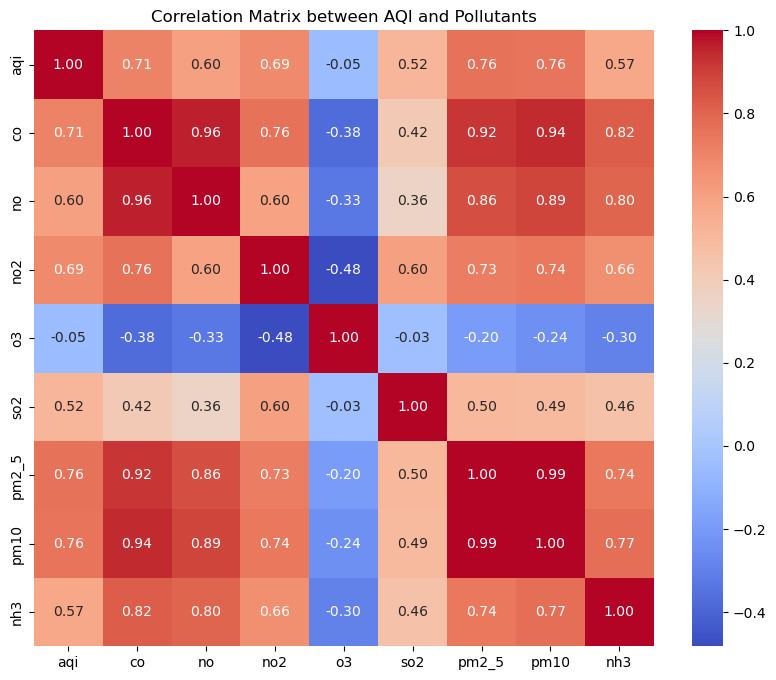

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
## Compute correlation matrix including AQI and pollutant concentrations
correlation_matrix = df_history_preprocessed[['aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix between AQI and Pollutants')
plt.show()

In the heatmap, it looks like there are some strong positive correlations between AQI and several pollutants such as CO, NO, and particulate matter (PM2.5 and PM10). This makes sense as these pollutants are known to contribute to the AQI. Conversely, there's a notable negative correlation between O3 (ozone) and some other pollutants, which might be due to the complex chemistry of ozone formation which can be inversely related to other pollutants under certain conditions.

- Distribution of the variables

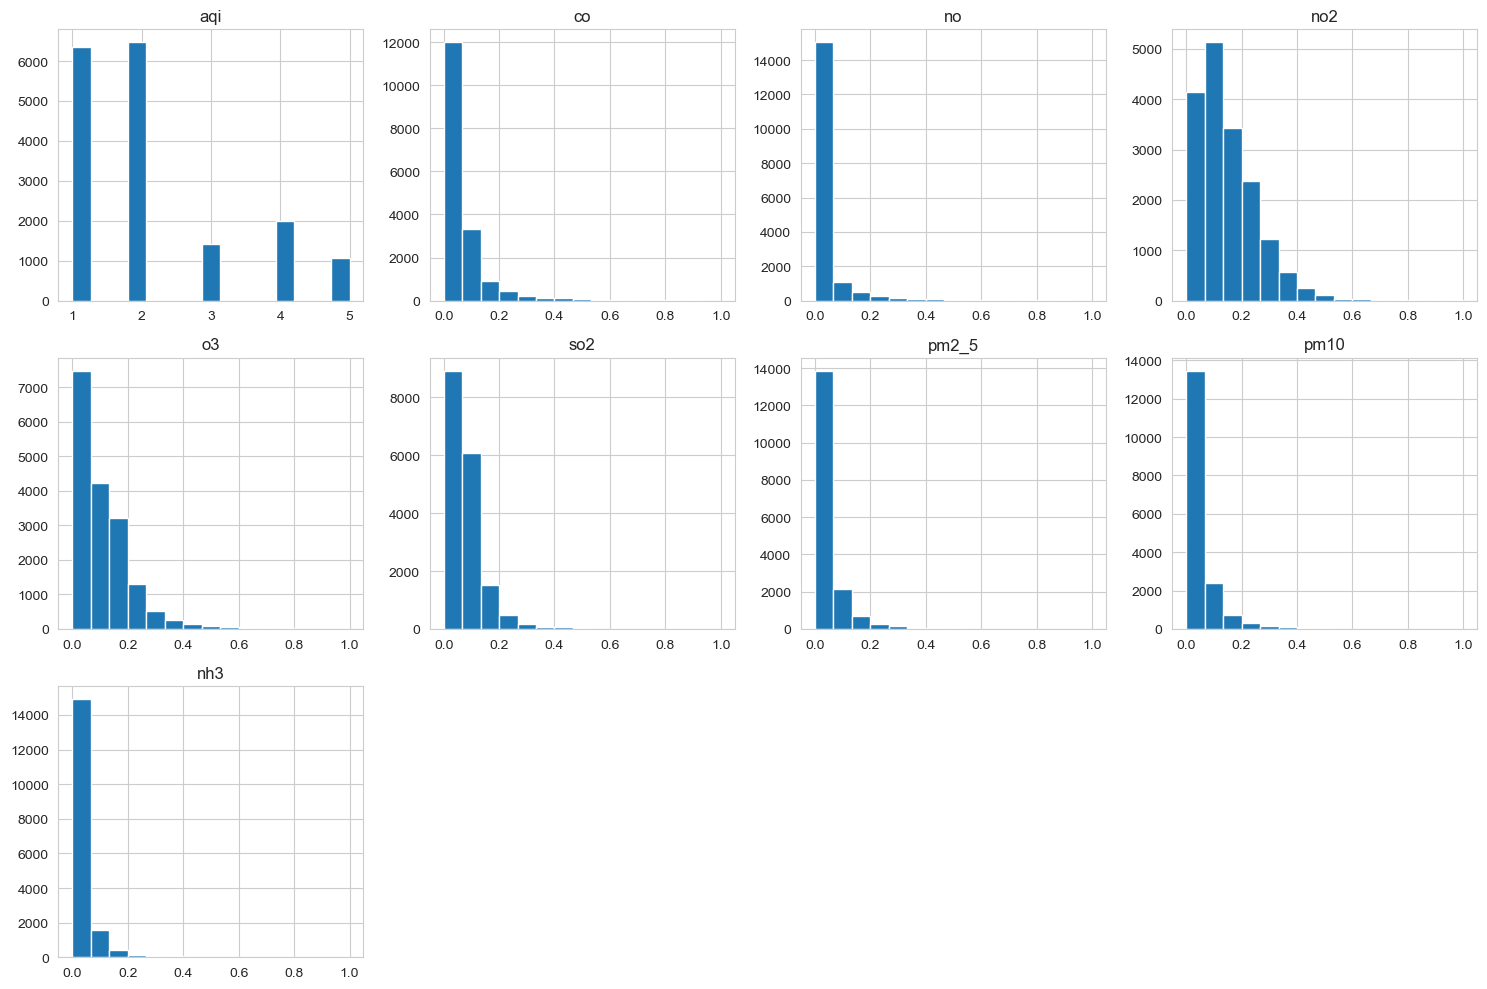

In [31]:
# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Plotting histograms for each variable
df_history_preprocessed.hist(bins=15, figsize=(15, 10), layout=(3, 4))

# Show the plot
plt.tight_layout()
plt.show()

- AQI category distribution

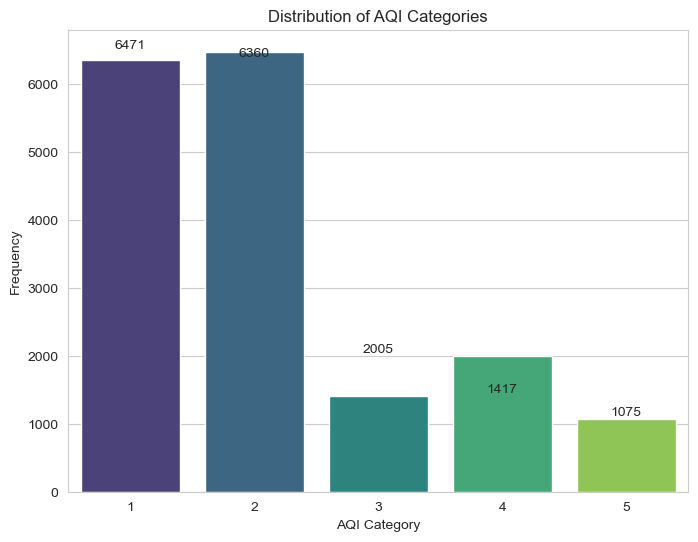

In [32]:
# Assuming 'aqi' is a categorical variable
aqi_counts = df_history_preprocessed['aqi'].value_counts()

# Plotting the distribution of AQI categories
plt.figure(figsize=(8, 6))
sns.barplot(x=aqi_counts.index, y=aqi_counts.values, palette="viridis")

# Annotating each bar with its count
for i, count in enumerate(aqi_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Show the plot
plt.xlabel('AQI Category')
plt.ylabel('Frequency')
plt.title('Distribution of AQI Categories')
plt.show()

### 5 -Model Training

- Random Forest

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Separation of training and test data sets
X = df_history_preprocessed.drop('aqi', axis=1)[["co", "no", "no2", "o3", "so2", "pm2_5", "pm10", "nh3"]]
y = df_history_preprocessed['aqi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Training the random forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

from sklearn.metrics import f1_score

# Prediction on the test data set
y_pred = model.predict(X_test)

# Assessment with F1 score
score_f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' takes account of class imbalance
print(f"Random Forest Score F1: {score_f1}")

Random Forest Score F1: 0.9904816221944474


- SVC

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Separation of training and test data sets
X = df_history_preprocessed.drop('aqi', axis=1)[["co", "no", "no2", "o3", "so2", "pm2_5", "pm10", "nh3"]]
y = df_history_preprocessed['aqi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Training the SVM model
model = SVC(random_state=42)
model.fit(X_train, y_train)

from sklearn.metrics import f1_score

# Prediction on the test data set
y_pred = model.predict(X_test)

# Assessment with F1 score
score_f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' takes account of class imbalance
print(f"SVM Score F1: {score_f1}")

SVM Score F1: 0.9159292909340025


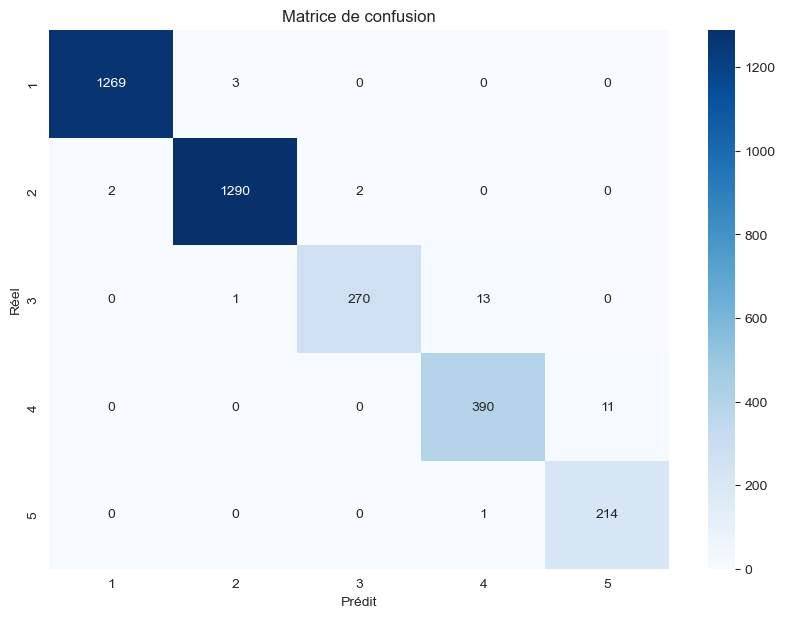

In [42]:
from sklearn.metrics import confusion_matrix

# Calculation of the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix with seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matrice de confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()